<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/HT_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
# Imports
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Paths and class names
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}
IMG_SIZE = 224

# Load and preprocess data
X, y = [], []
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(class_path):
        continue
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(class_mapping[class_name])

X = np.array(X, dtype=np.float32) / 255.0
y = to_categorical(y, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Loaded {len(X)} images.")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:140]:
    layer.trainable = False

# Custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]
)


Loaded 497 images.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 167s 12s/step - accuracy: 0.2734 - loss: 2.5026 - val_accuracy: 0.2000 - val_loss: 1.8510 - learning_rate: 1.0000e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 189s 10s/step - accuracy: 0.2911 - loss: 2.1472 - val_accuracy: 0.2000 - val_loss: 1.8128 - learning_rate: 1.0000e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 10s/step - accuracy: 0.2991 - loss: 1.7922 - val_accuracy: 0.2000 - val_loss: 1.7906 - learning_rate: 1.0000e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 145s 11s/step - accuracy: 0.3560 - loss: 1.7148 - val_accuracy: 0.2000 - val_loss: 1.7349 - learning_rate: 1.0000e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 11s/step - accuracy: 0.3895 - loss: 1.6275 - val_accuracy: 0.2000 - val_loss: 1.6764 - learning_rate: 1.0000e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 136s 11s/step - accuracy: 0.3896 - loss: 1.5150 - val_accuracy: 0.2300 - val_loss: 1.6325 - learning_rate: 1.0000e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 136s 11s/step - acc

In [7]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"❌ Test Loss: {loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.6953 - loss: 0.9838
✅ Test Accuracy: 72.00%
❌ Test Loss: 0.9482


In [8]:
# Save
model.save("resnet50_ovarian_cancer_model_tuned.h5")
print("✅ Model saved!")

✅ Model saved!


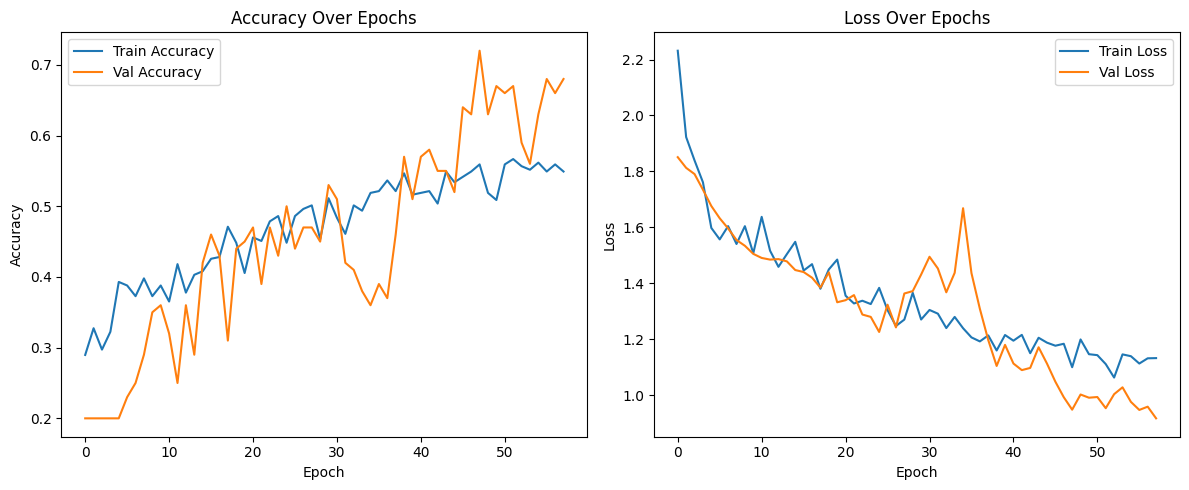

In [10]:
# Plotting
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)